In [16]:

from read_avi import *
os.chdir('/Users/davy/PycharmProjects/utd-mhad')
import tensorflow as tf
import random
import cv2
import matplotlib.cm as cm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.manifold import TSNE
from keras.src.layers import ConvLSTM2D
from keras.src.layers import MaxPooling3D
from tensorflow.keras.utils import plot_model
import numpy as np

In [17]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [18]:
CLASSES_LIST = [
    "RIGHT ARM SWIPE TO THE LEFT",
    "RIGHT ARM SWIPE TO THE RIGHT",
    "RIGHT HAND WAVE",
    "TWO HAND FRONT CLAP",
    "RIGHT ARM THROW",
    "CROSS ARMS IN THE CHEST",
    "BASKETBALL SHOOTING",
    "DRAW X",
    "DRAW CIRCLE (CLOCKWISE)",
    "DRAW CIRCLE (COUNTER CLOCKWISE)",
    "DRAW TRIANGLE",
    "BOWLING (RIGHT HAND)",
    "FRONT BOXING",
    "BASEBALL SWING FROM RIGHT",
    "TENNIS FOREHAND SWING",
    "ARM CURL (TWO ARMS)",
    "TENNIS SERVE",
    "TWO HAND PUSH",
    "KNOCK ON DOOR",
    "HAND CATCH",
    "PICK UP AND THROW",
    "JOGGING",
    "WALKING",
    "SIT TO STAND",
    "STAND TO SIT",
    "FORWARD LUNGE (LEFT FOOT FORWARD)",
    "SQUAT"
]

# Function to split the data into training and testing sets
def split_data(video_data, labels):
    one_hot_encoded_labels = to_categorical(labels - 1)
    X_train, X_test, y_train, y_test = train_test_split(video_data, one_hot_encoded_labels, test_size=0.2, random_state=seed_constant)
    return X_train, X_test, y_train, y_test


# Function to prepare data for machine learning training
def prepare_data_for_ml(directory, filesuffix):
    video_data, labels = process_avi_files(directory, filesuffix, None)
    # for video_num in range(0, len(video_data)):
    #     video_processor.save_video(video_data[video_num], output_file="out/vid/"+labels[video_num], frame_rate=video_processor.min_frame_count)
    # X_train, X_test, y_train, y_test = split_data(video_data, labels)
    return video_data, labels

# Prepare data for ML training
video_data, labels = prepare_data_for_ml(avi_files_directory, avi_files_suffix)

print(video_data.shape)


Total frames/RGBMPG:  33
(216, 33, 224, 224, 3)


In [19]:
# Specify the height and width to which each video frame will be resized in our dataset.
FRAME_HEIGHT , FRAME_WIDTH = video_data.shape[2:4]

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = video_data.shape[1]


In [20]:
# Split the Data into Train ( 75% ) and Test Set ( 25% ).
X_train, X_test, y_train, y_test = split_data(video_data, labels)

print(X_train.shape)

(172, 33, 224, 224, 3)


In [21]:




def create_convlstm_model():
    '''
    This function will construct the required convlstm model.
    Returns:
        model: It is the required constructed convlstm model.
    '''

    # We will use a Sequential model for model construction
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      FRAME_HEIGHT, FRAME_WIDTH, 3)))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    #model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(Flatten()) 
    
    model.add(Dense(len(CLASSES_LIST), activation = "softmax"))
    
    ########################################################################################################################
     
    # Display the models summary.
    model.summary()
    
    # Return the constructed convlstm model.
    return model

In [22]:
# Construct the required convlstm model.
convlstm_model = create_convlstm_model()

# Display the success message. 
print("Model Created Successfully!")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_4 (ConvLSTM2D)  (None, 33, 222, 222, 4)   1024      
                                                                 
 max_pooling3d_4 (MaxPoolin  (None, 33, 111, 111, 4)   0         
 g3D)                                                            
                                                                 
 time_distributed_3 (TimeDi  (None, 33, 111, 111, 4)   0         
 stributed)                                                      
                                                                 
 conv_lstm2d_5 (ConvLSTM2D)  (None, 33, 109, 109, 8)   3488      
                                                                 
 max_pooling3d_5 (MaxPoolin  (None, 33, 55, 55, 8)     0         
 g3D)                                                            
                                                      

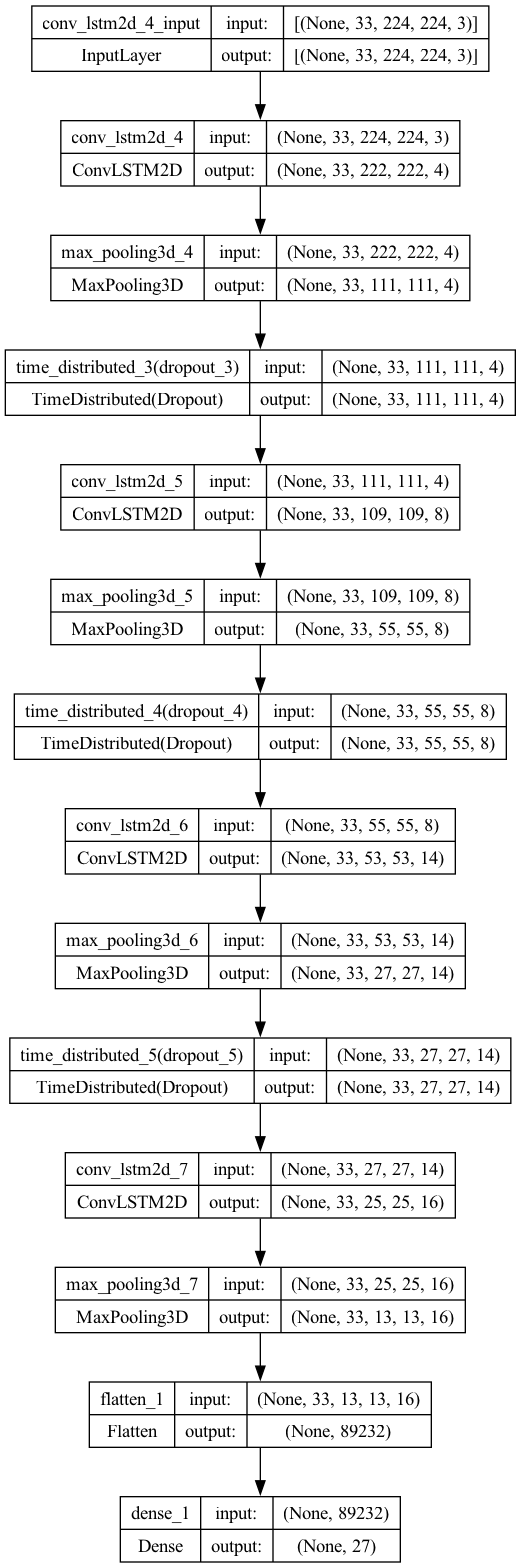

In [23]:
# Plot the structure of the contructed model.
plot_model(convlstm_model, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [24]:
# Create an Instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics values to the model
convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
convlstm_model_training_history = convlstm_model.fit(x = X_train, y = y_train, epochs = 50, batch_size = 2,
                                                     shuffle = True, validation_split = 0.2, 
                                                     callbacks = [early_stopping_callback])

(172, 27)
Epoch 1/50


2024-01-28 04:18:17.504624: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


 4/69 [>.............................] - ETA: 11:24 - loss: 5.3947 - accuracy: 0.0000e+00


KeyboardInterrupt



#### **<font style="color:rgb(134,19,348)">Evaluate the Trained Model</font>**

After training, we will evaluate the model on the test set.

In [ ]:
# Evaluate the trained model.
model_evaluation_history = convlstm_model.evaluate(X_test, y_test)

4/4 [==============================] - 14s 3s/step - loss: 0.8976 - accuracy: 0.8033


#### **<font style="color:rgb(134,19,348)">Save the Model</font>**

Now we will save the model to avoid training it from scratch every time we need the model.

In [ ]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'convlstm_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save your Model.
convlstm_model.save(model_file_name)

### **<font style="color:rgb(134,19,348)">Step 4.3: Plot Model’s Loss & Accuracy Curves</font>**


Now we will create a function **`plot_metric()`** to visualize the training and validation metrics. We already have separate metrics from our training and validation steps so now we just have to visualize them.

In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation 
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''
    
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

Now we will utilize the function **`plot_metric()`** created above, to visualize and understand the metrics.

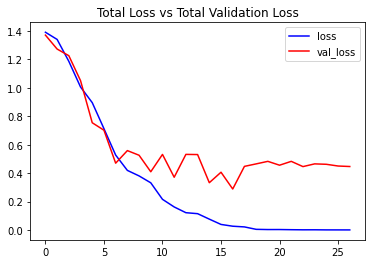

In [ ]:
# Visualize the training and validation loss metrices.
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

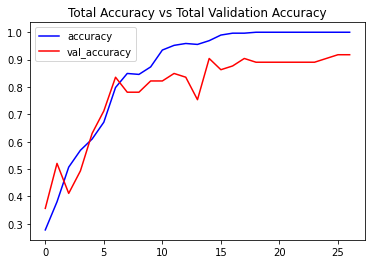

In [ ]:
# Visualize the training and validation accuracy metrices.
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy') 

## **<font style="color:rgb(134,19,348)">Step 5: Implement the LRCN Approach</font>**

In this step, we will implement the LRCN Approach by combining Convolution and LSTM layers in a single model. Another similar approach can be to use a CNN model and LSTM model trained separately. The CNN model can be used to extract spatial features from the frames in the video, and for this purpose, a pre-trained model can be used, that can be fine-tuned for the problem. And the LSTM model can then use the features extracted by CNN, to predict the action being performed in the video. 


But here, we will implement another approach known as the Long-term Recurrent Convolutional Network (LRCN), which combines CNN and LSTM layers in a single model. The Convolutional layers are used for spatial feature extraction from the frames, and the extracted spatial features are fed to LSTM layer(s) at each time-steps for temporal sequence modeling. This way the network learns spatiotemporal features directly in an end-to-end training, resulting in a robust model.

<center>
<img src='https://drive.google.com/uc?export=download&id=1I-q5yLsIoNh2chfzT7JYvra17FsXvdme'>
</center>


You can read the paper [Long-term Recurrent Convolutional Networks for Visual Recognition and Description](https://arxiv.org/abs/1411.4389?source=post_page---------------------------) by Jeff Donahue (CVPR 2015), to learn more about this architecture.

We will also use [**`TimeDistributed`**](https://keras.io/api/layers/recurrent_layers/time_distributed/) wrapper layer, which allows applying the same layer to every frame of the video independently. So it makes a layer (around which it is wrapped) capable of taking input of shape `(no_of_frames, width, height, num_of_channels)` if originally the layer's input shape was `(width, height, num_of_channels)` which is very beneficial as it allows to input the whole video into the model in a single shot. 

<center>
<img src='https://drive.google.com/uc?export=download&id=1CbauSm5XTY7ypHYBHH7rDSnJ5LO9CUWX' width=400>
</center>

### **<font style="color:rgb(134,19,348)">Step 5.1: Construct the Model</font>**

To implement our LRCN architecture, we will use time-distributed **`Conv2D`** layers which will be followed by **`MaxPooling2D`** and **`Dropout`** layers. The feature extracted from the **`Conv2D`** layers will be then flattened using the  **`Flatten`** layer and will be fed to a **`LSTM`** layer. The **`Dense`** layer with softmax activation will then use the output from the **`LSTM`** layer to predict the action being performed.

In [ ]:
def create_LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''

    # We will use a Sequential model for model construction.
    model = Sequential()
    
    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))
                                      
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(32))
                                      
    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    ########################################################################################################################

    # Display the models summary.
    model.summary()
    
    # Return the constructed LRCN model.
    return model

Now we will utilize the function **`create_LRCN_model()`** created above to construct the required `LRCN` model.

In [ ]:
# Construct the required LRCN model.
LRCN_model = create_LRCN_model()

# Display the success message.
print("Model Created Successfully!")

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_22 (TimeDis (None, 20, 64, 64, 16)    448       
_________________________________________________________________
time_distributed_23 (TimeDis (None, 20, 16, 16, 16)    0         
_________________________________________________________________
time_distributed_24 (TimeDis (None, 20, 16, 16, 16)    0         
_________________________________________________________________
time_distributed_25 (TimeDis (None, 20, 16, 16, 32)    4640      
_________________________________________________________________
time_distributed_26 (TimeDis (None, 20, 4, 4, 32)      0         
_________________________________________________________________
time_distributed_27 (TimeDis (None, 20, 4, 4, 32)      0         
_________________________________________________________________
time_distributed_28 (TimeDis (None, 20, 4, 4, 64)     

#### **<font style="color:rgb(134,19,348)">Check Model’s Structure:</font>**

Now we will use the **`plot_model()`** function to check the structure of the constructed `LRCN` model. As we had checked for the previous model.

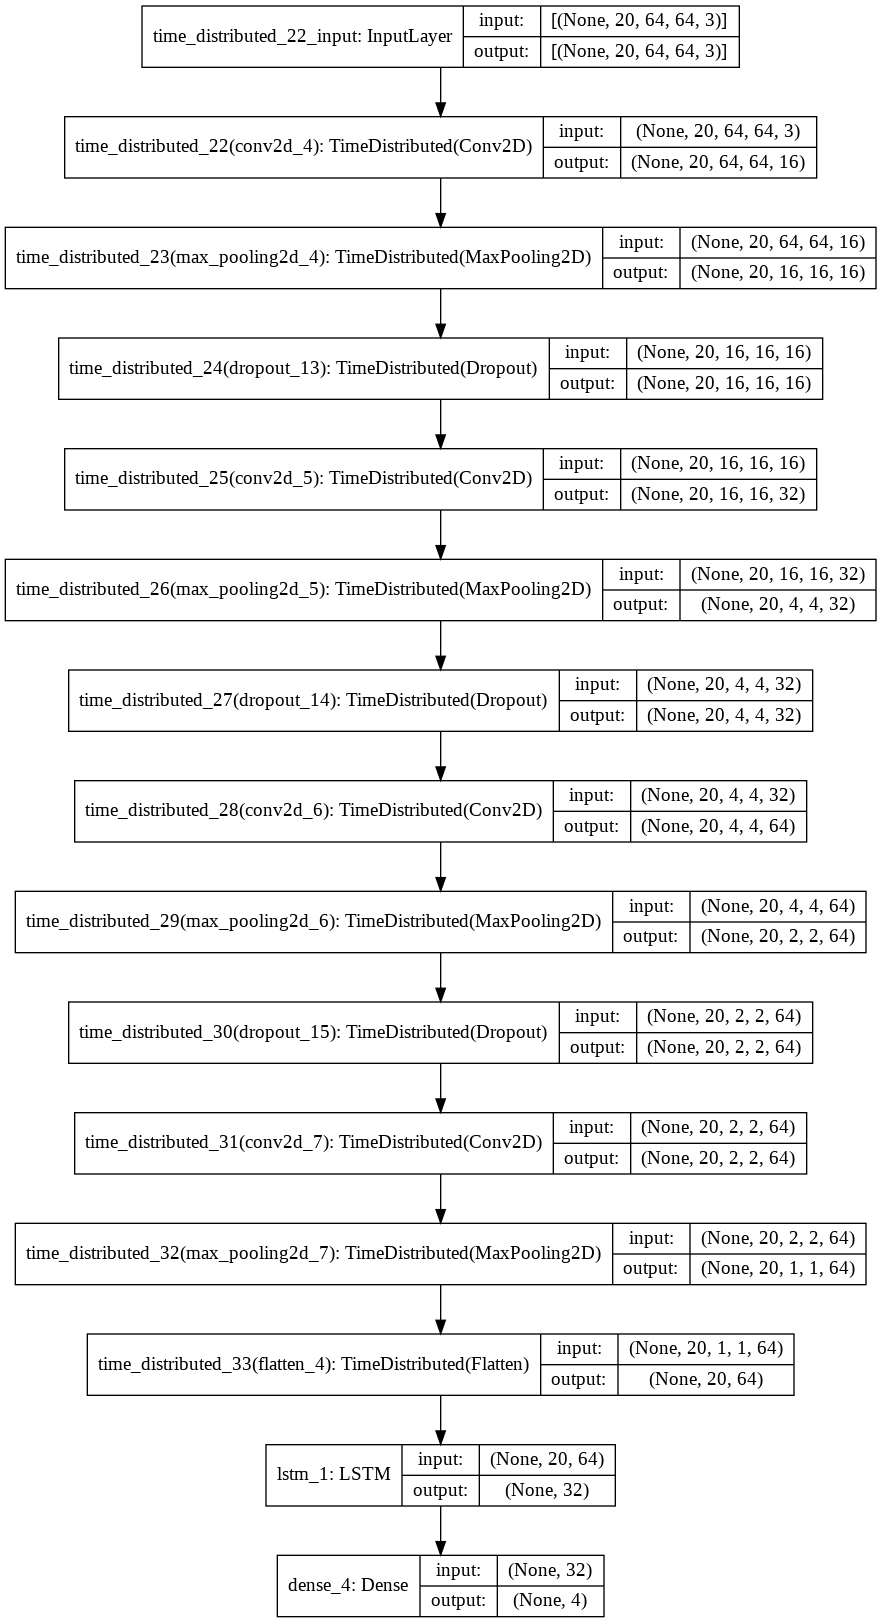

In [ ]:
# Plot the structure of the contructed LRCN model.
plot_model(LRCN_model, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

### **<font style="color:rgb(134,19,348)">Step 5.2: Compile & Train the Model</font>**


After checking the structure, we will compile and start training the model.

In [ ]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
 
# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
LRCN_model_training_history = LRCN_model.fit(x = X_train, y = y_train, epochs = 70, batch_size = 4 ,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/70
73/73 [==============================] - 17s 194ms/step - loss: 1.3965 - accuracy: 0.2979 - val_loss: 1.3717 - val_accuracy: 0.4384
Epoch 2/70
73/73 [==============================] - 13s 184ms/step - loss: 1.3252 - accuracy: 0.3425 - val_loss: 1.4161 - val_accuracy: 0.1781
Epoch 3/70
73/73 [==============================] - 14s 186ms/step - loss: 1.2344 - accuracy: 0.4555 - val_loss: 1.3471 - val_accuracy: 0.2877
Epoch 4/70
73/73 [==============================] - 14s 188ms/step - loss: 1.1417 - accuracy: 0.5240 - val_loss: 0.9880 - val_accuracy: 0.5753
Epoch 5/70
73/73 [==============================] - 14s 186ms/step - loss: 1.0090 - accuracy: 0.5856 - val_loss: 0.9365 - val_accuracy: 0.6164
Epoch 6/70
73/73 [==============================] - 13s 184ms/step - loss: 0.9444 - accuracy: 0.5959 - val_loss: 0.9169 - val_accuracy: 0.6575
Epoch 7/70
73/73 [==============================] - 13s 184ms/step - loss: 0.8739 - accuracy: 0.6233 - val_loss: 0.7460 - val_accuracy: 0.7260

#### **<font style="color:rgb(134,19,348)">Evaluating the trained Model</font>**

As done for the previous one, we will evaluate the `LRCN` model on the test set.

In [ ]:
# Evaluate the trained model.
model_evaluation_history = LRCN_model.evaluate(X_test, y_test)

4/4 [==============================] - 2s 418ms/step - loss: 0.2242 - accuracy: 0.9262


#### **<font style="color:rgb(134,19,348)">Save the Model</font>**

After that, we will save the model for future uses using the same technique we had used for the previous model.

In [ ]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
    
# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'LRCN_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save the Model.
LRCN_model.save(model_file_name)

### **<font style="color:rgb(134,19,348)">Step 5.3: Plot Model’s Loss & Accuracy Curves</font>**

Now we will utilize the function **`plot_metric()`** we had created above to visualize the training and validation metrics of this model.


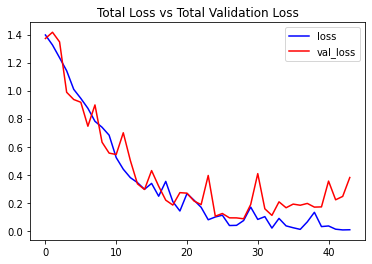

In [ ]:
# Visualize the training and validation loss metrices.
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

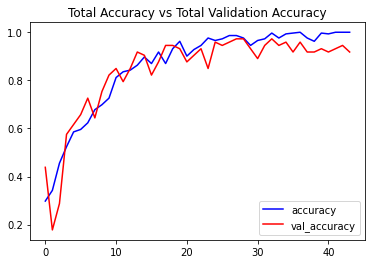

In [ ]:
# Visualize the training and validation accuracy metrices.
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

## **<font style="color:rgb(134,19,348)">Step 6: Test the Best Performing Model on YouTube videos</font>**

From the results, it seems that the LRCN model performed significantly well for a small number of classes. so in this step, we will put the `LRCN` model to test on some youtube videos. 

### **<font style="color:rgb(134,19,348)">Create a Function to Download YouTube Videos:</font>**

We will create a function **`download_youtube_videos()`** to download the YouTube videos first using **`pafy`** library. The library only requires a URL to a video to download it along with its associated metadata like the title of the video.

In [ ]:
def download_youtube_videos(youtube_video_url, output_directory):
     '''
    This function downloads the youtube video whose URL is passed to it as an argument.
    Args:
        youtube_video_url: URL of the video that is required to be downloaded.
        output_directory:  The directory path to which the video needs to be stored after downloading.
    Returns:
        title: The title of the downloaded youtube video.
    '''
 
     # Create a video object which contains useful information about the video.
     video = pafy.new(youtube_video_url)
 
     # Retrieve the title of the video.
     title = video.title
 
     # Get the best available quality object for the video.
     video_best = video.getbest()
 
     # Construct the output file path.
     output_file_path = f'{output_directory}/{title}.mp4'
 
     # Download the youtube video at the best available quality and store it to the contructed path.
     video_best.download(filepath = output_file_path, quiet = True)
 
     # Return the video title.
     return title

### **<font style="color:rgb(134,19,348)">Download a Test Video:</font>**

Now we will utilize the function **`download_youtube_videos()`** created above to download a youtube video on which the `LRCN` model will be tested.

In [ ]:
# Make the Output directory if it does not exist
test_videos_directory = 'test_videos'
os.makedirs(test_videos_directory, exist_ok = True)

# Download a YouTube Video.
video_title = download_youtube_videos('https://www.youtube.com/watch?v=8u0qjmHIOcE', test_videos_directory)

# Get the YouTube Video's path we just downloaded.
input_video_file_path = f'{test_videos_directory}/{video_title}.mp4'

### **<font style="color:rgb(134,19,348)">Create a Function To Perform Action Recognition on Videos</font>**

Next, we will create a function **`predict_on_video()`** that will simply read a video frame by frame from the path passed in as an argument and will perform action recognition on video and save the results.

In [ ]:
def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):
    '''
    This function will perform action recognition on a video using the LRCN model.
    Args:
    video_file_path:  The path of the video stored in the disk on which the action recognition is to be performed.
    output_file_path: The path where the ouput video with the predicted action being performed overlayed will be stored.
    SEQUENCE_LENGTH:  The fixed number of frames of a video that can be passed to the model as one sequence.
    '''

    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)

    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Initialize the VideoWriter Object to store the output video in the disk.
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'), 
                                   video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))

    # Declare a queue to store video frames.
    frames_queue = deque(maxlen = SEQUENCE_LENGTH)

    # Initialize a variable to store the predicted action being performed in the video.
    predicted_class_name = ''

    # Iterate until the video is accessed successfully.
    while video_reader.isOpened():

        # Read the frame.
        ok, frame = video_reader.read() 
        
        # Check if frame is not read properly then break the loop.
        if not ok:
            break

        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        normalized_frame = resized_frame / 255

        # Appending the pre-processed frame into the frames list.
        frames_queue.append(normalized_frame)

        # Check if the number of frames in the queue are equal to the fixed sequence length.
        if len(frames_queue) == SEQUENCE_LENGTH:

            # Pass the normalized frames to the model and get the predicted probabilities.
            predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_queue, axis = 0))[0]

            # Get the index of class with highest probability.
            predicted_label = np.argmax(predicted_labels_probabilities)

            # Get the class name using the retrieved index.
            predicted_class_name = CLASSES_LIST[predicted_label]

        # Write predicted class name on top of the frame.
        cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        # Write The frame into the disk using the VideoWriter Object.
        video_writer.write(frame)
        
    # Release the VideoCapture and VideoWriter objects.
    video_reader.release()
    video_writer.release()

### **<font style="color:rgb(134,19,348)">Perform Action Recognition on the Test Video</font>**

Now we will utilize the function **`predict_on_video()`** created above to perform action recognition on the test video we had downloaded using the function **`download_youtube_videos()`** and display the output video with the predicted action overlayed on it.

In [ ]:
# Construct the output video path.
output_video_file_path = f'{test_videos_directory}/{video_title}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'

# Perform Action Recognition on the Test Video.
predict_on_video(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)

# Display the output video.
VideoFileClip(output_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()

### **<font style="color:rgb(134,19,348)">Create a Function To Perform a Single Prediction on Videos</font>**


Now let's create a function that will perform a single prediction for the complete videos. We will extract evenly distributed **N** **`(SEQUENCE_LENGTH)`** frames from the entire video and pass them to the `LRCN` model. This approach is really useful when you are working with videos containing only one activity as it saves unnecessary computations and time in that scenario.  

In [ ]:
def predict_single_action(video_file_path, SEQUENCE_LENGTH):
    '''
    This function will perform single action recognition prediction on a video using the LRCN model.
    Args:
    video_file_path:  The path of the video stored in the disk on which the action recognition is to be performed.
    SEQUENCE_LENGTH:  The fixed number of frames of a video that can be passed to the model as one sequence.
    '''

    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)

    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Declare a list to store video frames we will extract.
    frames_list = []
    
    # Initialize a variable to store the predicted action being performed in the video.
    predicted_class_name = ''

    # Get the number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH),1)

    # Iterating the number of times equal to the fixed length of sequence.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Read a frame.
        success, frame = video_reader.read() 

        # Check if frame is not read properly then break the loop.
        if not success:
            break

        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        normalized_frame = resized_frame / 255
        
        # Appending the pre-processed frame into the frames list
        frames_list.append(normalized_frame)

    # Passing the  pre-processed frames to the model and get the predicted probabilities.
    predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_list, axis = 0))[0]

    # Get the index of class with highest probability.
    predicted_label = np.argmax(predicted_labels_probabilities)

    # Get the class name using the retrieved index.
    predicted_class_name = CLASSES_LIST[predicted_label]
    
    # Display the predicted action along with the prediction confidence.
    print(f'Action Predicted: {predicted_class_name}\nConfidence: {predicted_labels_probabilities[predicted_label]}')
        
    # Release the VideoCapture object. 
    video_reader.release()

### **<font style="color:rgb(134,19,348)">Perform Single Prediction on a Test Video</font>**

Now we will utilize the function **`predict_single_action()`** created above to perform a single prediction on a complete youtube test video that we will download using the function **`download_youtube_videos()`**, we had created above.

In [ ]:
# Download the youtube video.
video_title = download_youtube_videos('https://youtu.be/fc3w827kwyA', test_videos_directory)

# Construct tihe nput youtube video path
input_video_file_path = f'{test_videos_directory}/{video_title}.mp4'

# Perform Single Prediction on the Test Video.
predict_single_action(input_video_file_path, SEQUENCE_LENGTH)

# Display the input video.
VideoFileClip(input_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()

#  <center> <font style="color:rgb(234,19,148)">Join My Upcoming Computer Vision For Building Cutting Edge Applications Course</font>   </center>

A Course that goes beyond basic applications and teaches you how to create some next-level apps that utilize physics, deep learning (LSTM + CNN) + classical image processing, hand and body gestures to do a variety of very interesting things.
<center>
<img src='https://drive.google.com/uc?export=download&id=1GYO8Rg6l1ClLmEtPQz7Mwve-aSt9vvId'></center>

<br>
<br>

<center>  <a href="https://www.getdrip.com/forms/677961673/submissions/new"> <button>Join the Waitlist!</button>
</a></center>
    
